# EMERITUS CAPSTONE PROJECT
**_NUVEEN SALES ANALYSIS:_**
The aim of the project is to build a machine learning model to predict _next year_ sales based on different explanatory variables which describe _current year_ sales.

Once the Machine Learning model has been built, the next step is to evaluate the performance of our model so we can calibrate it according with the optimum outcome for the application.

Furthermore, some preparation to present the results of the model's benefits must be performed in order to communicate the results to **non-technical audiences**.

In [1]:
##IMPORTS SECTION
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
#REGRESSION MODEL
from sklearn.linear_model import Ridge, LogisticRegression
#CLASSIFICATIONS MODELS
from sklearn.ensemble import RandomForestClassifier
#METRICS
from sklearn.metrics import mean_squared_error, r2_score, roc_auc_score, classification_report, roc_curve, confusion_matrix

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
##TRANSFORMER: RARE LABEL ENCODER
class RareLabelEncoder(BaseEstimator, TransformerMixin):

    def __init__(self, threshold=0.05, variables=None):
        
        self.threshold = threshold
        
        if not isinstance(variables, list):
            self.variables = [variables]
        else:
            self.variables = variables

    def fit(self, X, y=None):
        
        self.encoder_dict_ = {}
        
        for var in self.variables:
            temp = pd.Series(X[var].value_counts() / np.float(len(X)))
            self.encoder_dict_[var] = list(temp[temp >= self.threshold].index)

        return self

    def transform(self, X):
        
        X = X.copy()
        
        for feature in self.variables:
            next_cat = self.encoder_dict_[feature][-1] + 1
            X[feature] = np.where(X[feature].isin(self.encoder_dict_[feature]), X[feature], next_cat)

        return X

In [3]:
##TRANSFORMER: LOGARITMIC TRANSFORMATION
class LogaritmicTransformation(BaseEstimator, TransformerMixin):

    def __init__(self, variables=None):
        
        if not isinstance(variables, list):
            self.variables = [variables]
        else:
            self.variables = variables

    def fit(self, X, y=None):
        #Method implemented as requirement by sklearn pipeline

        return self

    def transform(self, X):
        
        X = X.copy()
        
        for feature in self.variables:
            X[feature] = np.log1p(X[feature])

        return X

In [4]:
##LOAD DATASETS
dsadvr = pd.read_excel('./data/Transaction Data.xlsx',sheet_name='Transactions18')
dsfirm = pd.read_excel('./data/Firm Information.xlsx',sheet_name='Rep summary')

df_nuveen = pd.read_csv('./data/Nuveen Dataset.csv')
X = df_nuveen.drop(['sales_total','sales_12M','new_Fund_added_12M','sales_2019','Fund_added_2019'], axis=1)
yreg = df_nuveen['sales_2019']
ycls = df_nuveen['Fund_added_2019'].apply(lambda x: 1 if x > 0 else 0)

## ADVISER & FIRM MAPPERS

In [5]:
adviser_lookup = {idx: contact_id for idx, contact_id in enumerate(dsadvr['CONTACT_ID'])}
firm_lookup = {idx: contact_id for idx, contact_id in enumerate(dsfirm['Contact ID'])}

## MODEL EVALUATION AND CALIBRATION

In [6]:
##VARIABLES SELECTED AS PREDICTORS
DISCRETE_VARS = ['no_of_sales_12M_1','no_of_sales_12M_10K','no_of_funds_sold_12M_1','no_of_fund_sales_12M_10K',
                 'no_of_assetclass_sold_12M_1','no_of_assetclass_sales_12M_10K','No_of_fund_curr','No_of_asset_curr']

CONTINUOUS_VARS = ['AUM','sales_curr']

## SALES PREDICTION

A Regression model is used to predict sales but in order to evaluate the model performance, the problem will be treat it as Classification first, namely the problem is set to asnwer the question: Which are the advisers that **made a sale**?

The prediction of the Classification model is used to _filter_ the predictions made by the Regression model. Due to the Classification model has the task to separate the advisers that made a sale or not, the model is evaluated and then calibrated so its predictions can help us in the sales predictions.

In [7]:
y_sales = yreg.apply(lambda x: 1 if x > 0 else 0)

In [8]:
##SPLIT DATA INTO TRAIN & TEST
X_train, X_test, yc_train, yc_test = train_test_split(X, y_sales, test_size=0.1, random_state=5)

In [9]:
##PIPELINE ASSEMBLER
sales_clf = Pipeline(
    [
        ('rare_label_encoder', RareLabelEncoder(threshold=0.03, variables=DISCRETE_VARS)),
         
        ('scaler', StandardScaler()),
        
        ('pca', PCA(n_components=0.95, svd_solver='full')),
        
        ('log_reg', LogisticRegression(random_state=0))
    ]
)

In [10]:
sales_clf.fit(X_train, yc_train)

Pipeline(memory=None,
     steps=[('rare_label_encoder', RareLabelEncoder(threshold=0.03,
         variables=['no_of_sales_12M_1', 'no_of_sales_12M_10K', 'no_of_funds_sold_12M_1', 'no_of_fund_sales_12M_10K', 'no_of_assetclass_sold_12M_1', 'no_of_assetclass_sales_12M_10K', 'No_of_fund_curr', 'No_of_asset_curr'])), ('scaler', S...e, penalty='l2', random_state=0, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))])

## Receiver-Operating-Characteristic Curve

In [11]:
##TRUE-POSITIVE ; TRUE-NEGATIVE ; FALSE-POSITIVE ; FALSE-NEGATIVE CALCULATION
def tptn_fpfn_counts(row):
    if row['y_real'] == 1 and row['y_hat'] == 1:
        return 'TP'
    if row['y_real'] == 0 and row['y_hat'] == 0:
        return 'TN'
    if row['y_real'] == 0 and row['y_hat'] == 1:
        return 'FP'
    if row['y_real'] == 1 and row['y_hat'] == 0:
        return 'FN'
    

In [12]:
adviser_sales = pd.DataFrame(index=yc_test.index)
adviser_sales['y_real'] = yc_test
adviser_sales['y_pred'] = sales_clf.predict(X_test)
adviser_sales['y_score'] = sales_clf.predict_proba(X_test)[:,1]
adviser_sales['TP'] = 0
adviser_sales['TN'] = 0
adviser_sales['FP'] = 0
adviser_sales['FN'] = 0
adviser_sales['Thld'] = 0

In [13]:
tn,fp,fn,tp = confusion_matrix(adviser_sales['y_real'],adviser_sales['y_pred']).ravel()
print('TN:{0} FP:{1} N:{2}'.format(tn,fp,(tn+fp)))
print('TP:{0} FN:{1} P:{2}'.format(tp,fn,(tp+fn)))
confusion_matrix(adviser_sales['y_real'],adviser_sales['y_pred'])

TN:405 FP:75 N:480
TP:400 FN:121 P:521


array([[405,  75],
       [121, 400]], dtype=int64)

In [14]:
Thresholds = adviser_sales['y_score'].unique()
counts = []
for th in Thresholds:
    memo = {'TP':0,'TN':0,'FP':0,'FN':0,'Thld':0}
    adviser_sales['y_hat'] = (adviser_sales['y_score'] > th)*1
    adviser_sales['CM'] = adviser_sales.apply(tptn_fpfn_counts, axis=1)
    values = adviser_sales['CM'].value_counts().to_dict()
    memo['TP'] = values.get('TP',0)
    memo['TN'] = values.get('TN',0)
    memo['FP'] = values.get('FP',0)
    memo['FN'] = values.get('FN',0)
    memo['Thld'] = th
    counts.append(memo)
    
adviser_sales.drop(['y_hat','CM'],axis=1, inplace=True)
adviser_sales.head()

,y_real,y_pred,y_score,TP,TN,FP,FN,Thld
9668,0,1,0.902074,0,0,0,0,0
442,1,1,0.981503,0,0,0,0,0
4410,1,1,0.963846,0,0,0,0,0
2289,0,0,0.230744,0,0,0,0,0
2174,0,0,0.220453,0,0,0,0,0


In [15]:
def cm_values(val):
    
    def cm_count(row):
        if row['y_score'] == val['Thld']:
            row['TP'] = val['TP']
            row['TN'] = val['TN']
            row['FP'] = val['FP']
            row['FN'] = val['FN']
            row['Thld'] = val['Thld']
            
    return cm_count

In [16]:
for c in counts:
    for i in adviser_sales.index:
        if adviser_sales.loc[i,'y_score'] == c['Thld']:
            adviser_sales.loc[i,'TP'] = c['TP']
            adviser_sales.loc[i,'TN'] = c['TN']
            adviser_sales.loc[i,'FP'] = c['FP']
            adviser_sales.loc[i,'FN'] = c['FN']
            adviser_sales.loc[i,'Thld'] = c['Thld']

In [17]:
##TRUE-POSITIVE RATE & FALSE-POSITIVE RATE CALCULATION
adviser_sales['TPR'] = adviser_sales['TP']/(adviser_sales['TP'] + adviser_sales['FN'])
adviser_sales['FPR'] = adviser_sales['FP']/(adviser_sales['FP'] + adviser_sales['TN'])

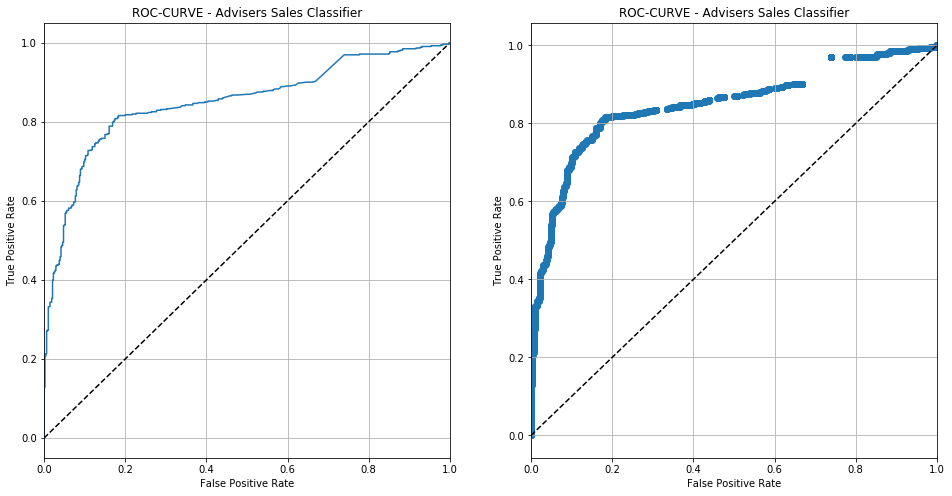

In [18]:
##ROC CURVE
fpr, tpr, thr = roc_curve(adviser_sales['y_real'], adviser_sales['y_score'])
roc_graph = pd.DataFrame({'fpr':fpr,'tpr':tpr,'thr':thr})
roc_graph['random'] = roc_graph['fpr']
fig, ax = plt.subplots(1,2,figsize=(16,8))
roc_graph.plot(x='fpr',y='random',ax=ax[0], grid=True, legend=False, style='k--')
roc_graph.plot(x='fpr',y='tpr', ax=ax[0], grid=True, legend=False)
ax[0].set_xlabel('False Positive Rate')
ax[0].set_ylabel('True Positive Rate')
ax[0].set_title('ROC-CURVE - Advisers Sales Classifier')

ax[1].scatter(adviser_sales['FPR'],adviser_sales['TPR'])
roc_graph.plot(x='fpr',y='random',ax=ax[1], grid=True, legend=False, style='k--')
ax[1].set_xlabel('False Positive Rate')
ax[1].set_ylabel('True Positive Rate')
ax[1].set_title('ROC-CURVE - Advisers Sales Classifier')
plt.show();

The ROC-Curve show us the relation between the `True Positive Rate` which is the model's ability to _find_ the cases of interest among all of them, namely how **sensitive** is the model to predict the class of interest. And the `False Positive Rate` which is the proportion of cases that were wgronly classified as _goog case_.

Another way to interpret the `True Positive Rate` is in terms of **benefits** and the `False Positive Rate` as the **cost** associated in our prediction. The point that intersects both values is the `Threshold` set by the model to _differenciate_ between both classes.

From the above ROC-Curves it can be noticed that a `Threshold` around **[0.2,0.83]** give us a better tradeoff to pedict more less _83%_ of the cases with a minimum cost of _20%_.

To optimize this threshold, it is convenient to estimate:
$$maxarg (True Positive Rate - False Positive Rate)$$


In [19]:
roc_auc_score(adviser_sales['y_real'],adviser_sales['y_score'])

0.8503418905950098

In [20]:
optimal = adviser_sales.copy()
optimal['TPR - FPR'] = optimal['TPR'] - optimal['FPR']
optimal.sort_values('TPR - FPR', ascending=False).head()

,y_real,y_pred,y_score,TP,TN,FP,FN,Thld,TPR,FPR,TPR - FPR
2231,0,0,0.250021,421,396,84,100,0.250021,0.808061,0.175000,0.633061
5582,0,0,0.243229,425,392,88,96,0.243229,0.815739,0.183333,0.632406
7109,0,0,0.267195,419,397,83,102,0.267195,0.804223,0.172917,0.631306
1112,1,0,0.251239,420,396,84,101,0.251239,0.806142,0.175000,0.631142
2527,0,0,0.249259,421,395,85,100,0.249259,0.808061,0.177083,0.630978


Above the five best scores are shown. It can be notices that the `Threshold` of _0.25018_ give us the highest benefits with the minimum cost.
This `Threshold` is used in our model to predict the advisers with better chance to make a sale.

In [21]:
##OPTIMAL PREDICTION THRESHOLD
th_pred = optimal.loc[2231,'Thld']
th_pred

0.2500212123098636

In [22]:
##PIPELINE ASSEMBLER
sales_reg = Pipeline(
    [
        ('rare_label_encoder', RareLabelEncoder(threshold=0.03, variables=DISCRETE_VARS)),
         
        ('log_transform', LogaritmicTransformation(variables=CONTINUOUS_VARS)),
         
        ('scaler', StandardScaler()),
        
        ('reg_model', Ridge(alpha=0.05, random_state=0))
    ]
)

In [23]:
##SPLIT DATA INTO TRAIN & TEST
X_train, X_test, yr_train, yr_test = train_test_split(X, yreg, test_size=0.1, random_state=5)

In [24]:
y_log_train = np.log1p(yr_train)
y_log_test = np.log1p(yr_test)

In [25]:
sales_reg.fit(X_train, y_log_train)

Pipeline(memory=None,
     steps=[('rare_label_encoder', RareLabelEncoder(threshold=0.03,
         variables=['no_of_sales_12M_1', 'no_of_sales_12M_10K', 'no_of_funds_sold_12M_1', 'no_of_fund_sales_12M_10K', 'no_of_assetclass_sold_12M_1', 'no_of_assetclass_sales_12M_10K', 'No_of_fund_curr', 'No_of_asset_curr'])), ('log_transf..., fit_intercept=True, max_iter=None,
   normalize=False, random_state=0, solver='auto', tol=0.001))])

In [26]:
param_reg = sales_reg.named_steps['reg_model']
param_reg.coef_ , param_reg.intercept_

(array([ 1.49855104,  0.68101055, -0.17561669,  0.19374866,  0.78915936,
        -0.17155089,  0.40323168, -0.12702488,  0.12869912,  1.55870331]),
 5.304209097584312)

In [27]:
reg_coef = list(param_reg.coef_)
reg_pred = DISCRETE_VARS + CONTINUOUS_VARS
for c,p in zip(reg_coef,reg_pred):
    print('Predictor: {0}, Coefficient = {1}'.format(p,round(c,3)))

Predictor: no_of_sales_12M_1, Coefficient = 1.499
Predictor: no_of_sales_12M_10K, Coefficient = 0.681
Predictor: no_of_funds_sold_12M_1, Coefficient = -0.176
Predictor: no_of_fund_sales_12M_10K, Coefficient = 0.194
Predictor: no_of_assetclass_sold_12M_1, Coefficient = 0.789
Predictor: no_of_assetclass_sales_12M_10K, Coefficient = -0.172
Predictor: No_of_fund_curr, Coefficient = 0.403
Predictor: No_of_asset_curr, Coefficient = -0.127
Predictor: AUM, Coefficient = 0.129
Predictor: sales_curr, Coefficient = 1.559


In [28]:
def sales_prediction(model_clf,model_reg,X,y_cls,y_reg,thld):
    df_pred = pd.DataFrame(index=y_cls.index)
    df_pred['yc_real'] = y_cls
    df_pred['yc_pred'] = (model_clf.predict_proba(X)[:,1]>thld)*1
    df_pred['y_score'] = model_clf.predict_proba(X)[:,1]
    df_pred['yr_real'] = y_reg
    df_pred.loc[df_pred['yc_pred'] == 0, 'yr_pred'] = 0
    df_pred.loc[df_pred['yr_pred'].isnull(), 'yr_pred'] = model_reg.predict(X.loc[df_pred['yr_pred'].isnull(), :])
    
    return df_pred

In [29]:
sales = sales_prediction(sales_clf,sales_reg,X_test,yc_test,y_log_test,th_pred)
sales.head()

,yc_real,yc_pred,y_score,yr_real,yr_pred
9668,0,1,0.902074,0.000000,7.759628
442,1,1,0.981503,8.308970,9.382702
4410,1,1,0.963846,12.131933,10.155033
2289,0,0,0.230744,0.000000,0.000000
2174,0,0,0.220453,0.000000,0.000000


MSE:15.579918767569797
RMSE:3.947140581176429


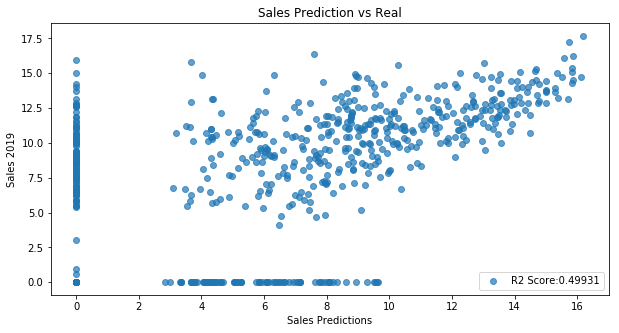

In [30]:
print('MSE:{}'.format(mean_squared_error(y_log_test,sales['yr_pred'])))
print('RMSE:{}'.format(np.sqrt(mean_squared_error(y_log_test,sales['yr_pred']))))
model_r2 = 'R2 Score:'+str(round(r2_score(y_log_test,sales['yr_pred']),5))
fig, ax = plt.subplots(1,1,figsize=(10,5))
ax.scatter(sales['yr_pred'],y_log_test,alpha=0.7)
ax.set_xlabel('Sales Predictions')
ax.set_ylabel('Sales 2019')
ax.set_title('Sales Prediction vs Real')
ax.legend([model_r2],loc='lower right')
plt.show();

In [31]:
sales['yr_real'].mean(),sales['yr_pred'].mean()

(5.458276868356198, 4.482403279699548)

## LIFT CHART

In [32]:
sales.sample(frac=0.3)['yc_real'].sum()/sales['yc_real'].sum()

0.29942418426103645

In [33]:
lift = sales[['yc_real','y_score']]
lift['cte'] = 1
lift.sort_values('y_score', ascending=False, inplace=True)
lift['Total %'] = lift['cte'].cumsum()/lift['cte'].sum()
lift['Target %'] = lift['yc_real'].cumsum()/lift['yc_real'].sum()
lift['Baseline'] = lift['Total %']
lift['y_sort'] = lift['yc_real'].sort_values(ascending=False).values
lift['Ideal Model'] = lift['y_sort'].cumsum()/lift['y_sort'].sum()
lift.drop(['cte','y_sort'],axis=1,inplace=True)
lift.head()

,yc_real,y_score,Total %,Target %,Baseline,Ideal Model
7690,1,1.0,0.000999,0.001919,0.000999,0.001919
8371,1,1.0,0.001998,0.003839,0.001998,0.003839
7317,1,1.0,0.002997,0.005758,0.002997,0.005758
8123,1,1.0,0.003996,0.007678,0.003996,0.007678
9952,1,1.0,0.004995,0.009597,0.004995,0.009597


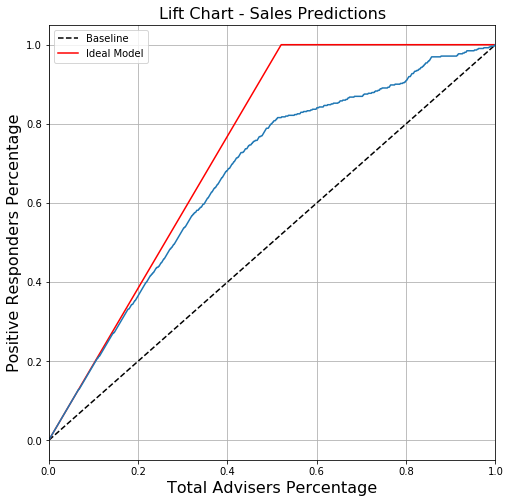

In [34]:
fig, ax = plt.subplots(1,1,figsize=(8,8))
lift.plot(x='Total %',y='Baseline',ax=ax, grid=True, legend=True, style='k--')
lift.plot(x='Total %',y='Ideal Model',ax=ax, grid=True, legend=True, style='r')
lift.plot(x='Total %',y='Target %', ax=ax, grid=True, legend=False)
ax.set_xlabel('Total Advisers Percentage',fontsize=16)
ax.set_ylabel('Positive Responders Percentage',fontsize=16)
ax.set_title('Lift Chart - Sales Predictions', fontsize=16);

In [35]:
def up_lift(df,target,frac):
    find = df.head(round(len(df)*frac))[target].sum()/df[target].sum()
    lift = find/frac
    return find,lift

In [36]:
##BASE RATE:
BR = lift['yc_real'].sum()/len(lift)
print('Base Rate:',BR)
print('Target Mean:',lift['yc_real'].mean())

Base Rate: 0.5204795204795205
Target Mean: 0.5204795204795205


In [37]:
gain, model_lift = up_lift(lift,'yc_real',0.1)
print('Gain:{0}[%] , Model-Lift:{1}'.format(round(gain*100,2),round(model_lift,2)))

Gain:19.0[%] , Model-Lift:1.9


In [38]:
rango = np.linspace(0.1,1.0,100)
lift_look = {}
for f in rango:
    fr = float(round(f,2))
    g, lf = up_lift(lift,'yc_real',fr)
    lift_look[fr] = (g,lf)

In [39]:
fractions = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
for f in fractions:
    print('Gain:{0} Lift:{1}'.format(lift_look[f][0],lift_look[f][1]))
    
# lift_look[0.85]

Gain:0.19001919385796545 Lift:1.9001919385796544
Gain:0.3646833013435701 Lift:1.8234165067178503
Gain:0.5316698656429942 Lift:1.7722328854766476
Gain:0.6813819577735125 Lift:1.7034548944337813
Gain:0.800383877159309 Lift:1.600767754318618
Gain:0.8406909788867563 Lift:1.401151631477927
Gain:0.8694817658349329 Lift:1.2421168083356184
Gain:0.9097888675623801 Lift:1.137236084452975
Gain:0.9712092130518234 Lift:1.0791213478353594
Gain:1.0 Lift:1.0


In [40]:
lift_tab = lift.copy()

In [41]:
lift_tab['sales 2019'] = np.expm1(sales['yr_real'])
lift_tab['sales pred'] = np.expm1(sales['yr_pred'])
lift_tab['deciles'] = pd.qcut(lift_tab['y_score'], 10, labels=False)
lift_tab['intervals'] = pd.qcut(lift_tab['y_score'], 10)
lift_tab['contact_id'] = lift_tab.index.map(adviser_lookup)

In [71]:
lift_tab.head()

,yc_real,y_score,Total %,Target %,Baseline,Ideal Model,sales 2019,sales pred,deciles,intervals,contact_id
7690,1,1.0,0.000999,0.001919,0.000999,0.001919,3.575736e+06,7.500616e+06,9,"(0.9752, 1.0]",85102151194243996323
8371,1,1.0,0.001998,0.003839,0.001998,0.003839,1.083940e+07,7.644587e+06,9,"(0.9752, 1.0]",0225117
7317,1,1.0,0.002997,0.005758,0.002997,0.005758,4.867638e+07,1.067456e+07,9,"(0.9752, 1.0]",0268477
8123,1,1.0,0.003996,0.007678,0.003996,0.007678,9.396985e+06,5.787878e+06,9,"(0.9752, 1.0]",4435333
9952,1,1.0,0.004995,0.009597,0.004995,0.009597,3.136082e+07,6.882202e+06,9,"(0.9752, 1.0]",85201122073118152417


In [43]:
sales_char = (lift_tab.groupby('deciles')
              .agg({'sales 2019':'mean','sales pred':'mean','Target %':'sum','yc_real':'sum','contact_id':'count'})
              #.droplevel(0, axis=1)
              .reset_index()
             )
sales_char['deciles'] = sales_char['deciles'].apply(lambda x: (x-10)*-1)
sales_char['response %'] = (sales_char['yc_real']/sales_char['yc_real'].sum())*100
sales_char

,deciles,sales 2019,sales pred,Target %,yc_real,contact_id,response %
0,10,5.451038e+03,0.000000e+00,99.470250,15,101,2.879079
1,9,1.250336e+05,0.000000e+00,103.328215,36,109,6.909789
2,8,5.407847e+03,0.000000e+00,84.245681,17,95,3.262956
3,7,1.859487e+04,0.000000e+00,84.641075,17,99,3.262956
4,6,3.208304e+04,1.183073e+01,79.846449,19,97,3.646833
5,5,1.290220e+05,2.315328e+02,74.397313,62,100,11.900192
6,4,8.404567e+04,4.731016e+03,60.642994,78,100,14.971209
7,3,2.037321e+05,2.655563e+04,44.859885,87,100,16.698656
8,2,4.559588e+05,1.087589e+05,27.994242,91,100,17.466411
9,1,1.875234e+06,1.846627e+06,9.629559,99,100,19.001919


In [44]:
sales_char['yc_real'].sum()

521

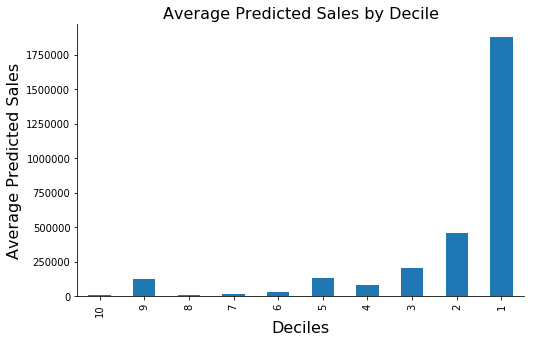

In [45]:
fig, ax = plt.subplots(figsize=(8,5))
sales_char.plot(kind='bar', x='deciles', y='sales 2019', ax=ax, legend=None)
ax.set_xlabel("Deciles", fontsize=16)
ax.set_ylabel("Average Predicted Sales", fontsize=16)
ax.set_title("Average Predicted Sales by Decile", fontsize=16)
ax.spines['top'].set_visible(False);
ax.spines['right'].set_visible(False);

## ADDING NEW FUND PREDICTION

In [50]:
##SPLIT DATA INTO TRAIN & TEST
X_train, X_test, yf_train, yf_test = train_test_split(X, ycls, test_size=0.1, random_state=5)

In [51]:
##PIPELINE ASSEMBLER
fund_clf = Pipeline(
    [
        ('rare_label_encoder', RareLabelEncoder(threshold=0.03, variables=DISCRETE_VARS)),
         
        ('scaler', StandardScaler()),
        
        ('pca', PCA(n_components=0.95, svd_solver='full')),
        
        ('class_model', RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0, class_weight='balanced'))

    ]
)

In [52]:
fund_clf.fit(X_train,yf_train)

Pipeline(memory=None,
     steps=[('rare_label_encoder', RareLabelEncoder(threshold=0.03,
         variables=['no_of_sales_12M_1', 'no_of_sales_12M_10K', 'no_of_funds_sold_12M_1', 'no_of_fund_sales_12M_10K', 'no_of_assetclass_sold_12M_1', 'no_of_assetclass_sales_12M_10K', 'No_of_fund_curr', 'No_of_asset_curr'])), ('scaler', S...mators=100, n_jobs=None, oob_score=False, random_state=0,
            verbose=0, warm_start=False))])

In [53]:
new_fund = pd.DataFrame(index=yf_test.index)
new_fund['y_real'] = yf_test
new_fund['y_pred'] = fund_clf.predict(X_test)
new_fund['y_score'] = fund_clf.predict_proba(X_test)[:,1]

In [54]:
##EVALUATION
print('ROC-AUC:{}'.format(roc_auc_score(yf_test,new_fund['y_score'])))
print('Classification Report:')
print(classification_report(yf_test,new_fund['y_pred']))

ROC-AUC:0.7165061613337474
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.59      0.70       740
           1       0.40      0.77      0.52       261

   micro avg       0.64      0.64      0.64      1001
   macro avg       0.64      0.68      0.61      1001
weighted avg       0.75      0.64      0.66      1001



## Receiver-Operating-Characteristic Curve

In [55]:
tn,fp,fn,tp = confusion_matrix(new_fund['y_real'],new_fund['y_pred']).ravel()
print('TN:{0} FP:{1} N:{2}'.format(tn,fp,(tn+fp)))
print('TP:{0} FN:{1} P:{2}'.format(tp,fn,(tp+fn)))
confusion_matrix(new_fund['y_real'],new_fund['y_pred'])

TN:436 FP:304 N:740
TP:200 FN:61 P:261


array([[436, 304],
       [ 61, 200]], dtype=int64)

In [56]:
new_fund['TP'] = 0
new_fund['TN'] = 0
new_fund['FP'] = 0
new_fund['FN'] = 0
new_fund['Thld'] = 0

Thresholds = new_fund['y_score'].unique()
counts = []
for th in Thresholds:
    memo = {'TP':0,'TN':0,'FP':0,'FN':0,'Thld':0}
    new_fund['y_hat'] = (new_fund['y_score'] > th)*1
    new_fund['CM'] = new_fund.apply(tptn_fpfn_counts, axis=1)
    values = new_fund['CM'].value_counts().to_dict()
    memo['TP'] = values.get('TP',0)
    memo['TN'] = values.get('TN',0)
    memo['FP'] = values.get('FP',0)
    memo['FN'] = values.get('FN',0)
    memo['Thld'] = th
    counts.append(memo)
    
new_fund.drop(['y_hat','CM'],axis=1, inplace=True)
new_fund.head()

,y_real,y_pred,y_score,TP,TN,FP,FN,Thld
9668,0,1,0.605113,0,0,0,0,0
442,1,1,0.698362,0,0,0,0,0
4410,1,1,0.614072,0,0,0,0,0
2289,0,0,0.283073,0,0,0,0,0
2174,0,0,0.339691,0,0,0,0,0


In [57]:
for c in counts:
    for i in new_fund.index:
        if new_fund.loc[i,'y_score'] == c['Thld']:
            new_fund.loc[i,'TP'] = c['TP']
            new_fund.loc[i,'TN'] = c['TN']
            new_fund.loc[i,'FP'] = c['FP']
            new_fund.loc[i,'FN'] = c['FN']
            new_fund.loc[i,'Thld'] = c['Thld']

In [58]:
##TRUE-POSITIVE RATE & FALSE-POSITIVE RATE CALCULATION
new_fund['TPR'] = new_fund['TP']/(new_fund['TP'] + new_fund['FN'])
new_fund['FPR'] = new_fund['FP']/(new_fund['FP'] + new_fund['TN'])

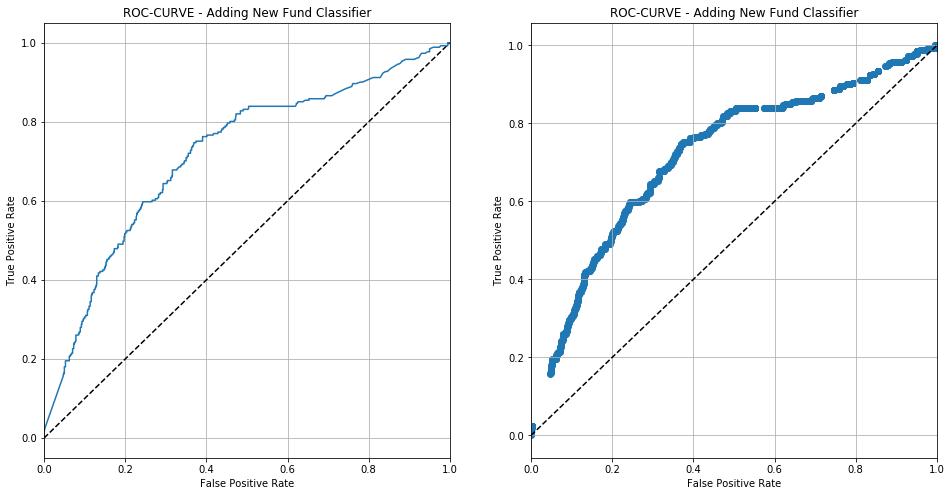

In [59]:
fpr, tpr, thr = roc_curve(new_fund['y_real'], new_fund['y_score'])
roc_fund = pd.DataFrame({'fpr':fpr,'tpr':tpr,'thr':thr})
roc_fund['random'] = roc_fund['fpr']
fig, ax = plt.subplots(1,2,figsize=(16,8))
roc_fund.plot(x='fpr',y='random',ax=ax[0], grid=True, legend=False, style='k--')
roc_fund.plot(x='fpr',y='tpr', ax=ax[0], grid=True, legend=False)
ax[0].set_xlabel('False Positive Rate')
ax[0].set_ylabel('True Positive Rate')
ax[0].set_title('ROC-CURVE - Adding New Fund Classifier')

ax[1].scatter(new_fund['FPR'],new_fund['TPR'])
roc_fund.plot(x='fpr',y='random',ax=ax[1], grid=True, legend=False, style='k--')
ax[1].set_xlabel('False Positive Rate')
ax[1].set_ylabel('True Positive Rate')
ax[1].set_title('ROC-CURVE - Adding New Fund Classifier')
plt.show();

In [60]:
optimal = new_fund.copy()
optimal['TPR - FPR'] = optimal['TPR'] - optimal['FPR']
optimal.sort_values('TPR - FPR', ascending=False).head()

,y_real,y_pred,y_score,TP,TN,FP,FN,Thld,TPR,FPR,TPR - FPR
2693,0,1,0.512014,195,467,273,66,0.512014,0.747126,0.368919,0.378208
42,0,1,0.511902,195,466,274,66,0.511902,0.747126,0.370270,0.376856
7062,0,1,0.509687,196,463,277,65,0.509687,0.750958,0.374324,0.376634
9620,0,1,0.511649,195,465,275,66,0.511649,0.747126,0.371622,0.375505
1360,0,1,0.509061,196,462,278,65,0.509061,0.750958,0.375676,0.375282


In [61]:
##OPTIMAL PREDICTION THRESHOLD
th_pred = optimal.loc[9675,'Thld']
th_pred

0.5172844135759621

In [62]:
cal_fund = pd.DataFrame(index=yf_test.index)
cal_fund['y_real'] = yf_test
cal_fund['y_pred'] = (fund_clf.predict_proba(X_test)[:,1] > th_pred)*1
cal_fund['y_score'] = fund_clf.predict_proba(X_test)[:,1]

In [63]:
tn,fp,fn,tp = confusion_matrix(cal_fund['y_real'],cal_fund['y_pred']).ravel()
print('TN:{0} FP:{1} N:{2}'.format(tn,fp,(tn+fp)))
print('TP:{0} FN:{1} P:{2}'.format(tp,fn,(tp+fn)))
confusion_matrix(cal_fund['y_real'],cal_fund['y_pred'])

TN:475 FP:265 N:740
TP:188 FN:73 P:261


array([[475, 265],
       [ 73, 188]], dtype=int64)

In [64]:
##EVALUATION
print('ROC-AUC:{}'.format(roc_auc_score(yf_test,cal_fund['y_score'])))
print('Classification Report:')
print(classification_report(yf_test,cal_fund['y_pred']))

ROC-AUC:0.7165061613337474
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.64      0.74       740
           1       0.42      0.72      0.53       261

   micro avg       0.66      0.66      0.66      1001
   macro avg       0.64      0.68      0.63      1001
weighted avg       0.75      0.66      0.68      1001



In [65]:
lfc_fund = cal_fund.copy()

## LIFT CHART

In [66]:
lift = lfc_fund[['y_real','y_score']]
lift['cte'] = 1
lift.sort_values('y_score', ascending=False, inplace=True)
lift['Total %'] = lift['cte'].cumsum()/lift['cte'].sum()
lift['Target %'] = lift['y_real'].cumsum()/lift['y_real'].sum()
lift['Baseline'] = lift['Total %']
lift['y_sort'] = lift['y_real'].sort_values(ascending=False).values
lift['Ideal Model'] = lift['y_sort'].cumsum()/lift['y_sort'].sum()
lift.drop(['cte','y_sort'],axis=1,inplace=True)
lift.head()

,y_real,y_score,Total %,Target %,Baseline,Ideal Model
7047,1,0.804882,0.000999,0.003831,0.000999,0.003831
8243,1,0.796677,0.001998,0.007663,0.001998,0.007663
4247,1,0.796187,0.002997,0.011494,0.002997,0.011494
7690,1,0.788842,0.003996,0.015326,0.003996,0.015326
7455,1,0.772198,0.004995,0.019157,0.004995,0.019157


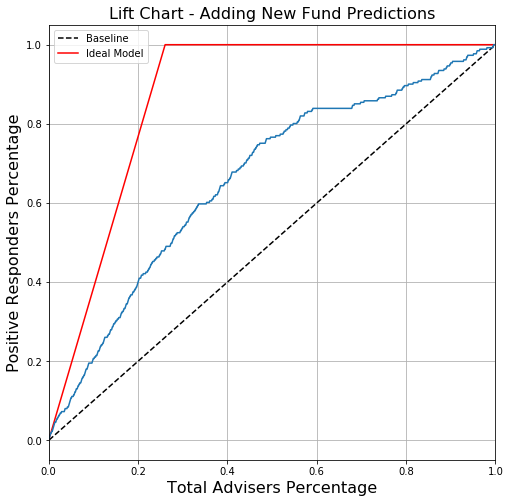

In [67]:
fig, ax = plt.subplots(1,1,figsize=(8,8))
lift.plot(x='Total %',y='Baseline',ax=ax, grid=True, legend=True, style='k--')
lift.plot(x='Total %',y='Ideal Model',ax=ax, grid=True, legend=True, style='r')
lift.plot(x='Total %',y='Target %', ax=ax, grid=True, legend=False)
ax.set_xlabel('Total Advisers Percentage',fontsize=16)
ax.set_ylabel('Positive Responders Percentage',fontsize=16)
ax.set_title('Lift Chart - Adding New Fund Predictions',fontsize=16);

In [68]:
##BASE RATE:
BR = lift['y_real'].sum()/len(lift)
print('Base Rate:',BR)
print('Target Mean:',lift['y_real'].mean())

Base Rate: 0.26073926073926074
Target Mean: 0.26073926073926074


In [69]:
rng = np.linspace(0.1,1.0,100)
lift_lkup = {}
for f in rng:
    fr = float(round(f,2))
    g,lf = up_lift(lift,'y_real',fr)
    lift_lkup[fr] = (g,lf)

In [70]:
fractions = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
for f in fractions:
    print('Gain:{0} Lift:{1}'.format(lift_lkup[f][0],lift_lkup[f][1]))

Gain:0.20689655172413793 Lift:2.068965517241379
Gain:0.39846743295019155 Lift:1.9923371647509576
Gain:0.5363984674329502 Lift:1.7879948914431674
Gain:0.6513409961685823 Lift:1.6283524904214557
Gain:0.7662835249042146 Lift:1.5325670498084292
Gain:0.8390804597701149 Lift:1.3984674329501916
Gain:0.8544061302681992 Lift:1.2205801860974275
Gain:0.896551724137931 Lift:1.1206896551724137
Gain:0.9540229885057471 Lift:1.0600255427841634
Gain:1.0 Lift:1.0


In [73]:
lift.head(10)

,y_real,y_score,Total %,Target %,Baseline,Ideal Model
7047,1,0.804882,0.000999,0.003831,0.000999,0.003831
8243,1,0.796677,0.001998,0.007663,0.001998,0.007663
4247,1,0.796187,0.002997,0.011494,0.002997,0.011494
7690,1,0.788842,0.003996,0.015326,0.003996,0.015326
7455,1,0.772198,0.004995,0.019157,0.004995,0.019157
1801,0,0.770371,0.005994,0.019157,0.005994,0.022989
5607,1,0.766610,0.006993,0.022989,0.006993,0.026820
9520,0,0.765539,0.007992,0.022989,0.007992,0.030651
4505,1,0.765539,0.008991,0.026820,0.008991,0.034483
4070,1,0.765539,0.009990,0.030651,0.009990,0.038314


In [86]:
lift_chr = lift.copy()
lift_chr['deciles'] = pd.qcut(lift_tab['y_score'], 10, labels=False)
lift_chr['intervals'] = pd.qcut(lift_tab['y_score'], 10)
lift_chr['contact_id'] = lift_tab.index.map(adviser_lookup)
lift_chr['intervals'].value_counts()

(0.2157, 0.2161]    109
(0.2094, 0.2157]    101
(0.9752, 1.0]       100
(0.9241, 0.9752]    100
(0.8155, 0.9241]    100
(0.6679, 0.8155]    100
(0.3079, 0.6679]    100
(0.2181, 0.2223]     99
(0.2223, 0.3079]     97
(0.2161, 0.2181]     95
Name: intervals, dtype: int64

In [94]:
fund_char = (lift_chr.groupby('deciles')
              .agg({'y_real':'sum','contact_id':'count','y_score':'mean'})
              #.droplevel(0, axis=1)
              .reset_index()
             )
fund_char['deciles'] = fund_char['deciles'].apply(lambda x: (x-10)*-1)
fund_char['Probability'] = round(fund_char['y_real']/fund_char['contact_id'],2)
fund_char

,deciles,y_real,contact_id,y_score,Probability
0,10,8,101,0.267060,0.08
1,9,36,109,0.598557,0.33
2,8,15,95,0.265432,0.16
3,7,13,99,0.279410,0.13
4,6,11,97,0.315402,0.11
5,5,28,100,0.525844,0.28
6,4,22,100,0.513186,0.22
7,3,34,100,0.575147,0.34
8,2,40,100,0.631074,0.40
9,1,54,100,0.678046,0.54


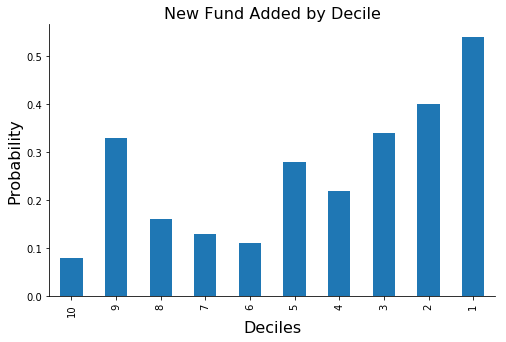

In [99]:
fig, ax = plt.subplots(figsize=(8,5))
fund_char.plot(kind='bar', x='deciles', y='Probability', ax=ax, legend=None)
ax.set_xlabel("Deciles", fontsize=16)
ax.set_ylabel("Probability", fontsize=16)
ax.set_title("New Fund Added by Decile", fontsize=16)
ax.spines['top'].set_visible(False);
ax.spines['right'].set_visible(False);